In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import derivative, MLP, init_weights
import warnings
from scat_circ import u_exact_calc_for_pinns
from scat_circ import *
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

In [19]:
def f(model, x_f, y_f, k):
    
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag
    
    return f_u_real, f_u_imag

def mse_f(model, x_f, y_f, k):
    # Calcular f(x, y) a partir de la red neuronal
    f_u_real, f_u_imag = f(model, x_f, y_f, k)
    
    # Calcular el error cuadrático medio para las partes real e imaginaria
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sumar los errores para obtener el MSE total
    mse = error_f_real + error_f_imag
      
    return mse

In [20]:
def mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t,k):

    #----------------------------------------------------
    # Inner
    domain_inner = torch.stack((x_inner, y_inner), axis=1)
    u_inner = model(domain_inner)
    u_real_inner = u_inner[:, 0]
    u_imag_inner = u_inner[:, 1]
    u_inner_real_teo = torch.real(u_inner_t)
    u_inner_imag_teo = torch.imag(u_inner_t)
    error_real_inner = u_real_inner - u_inner_real_teo
    error_imag_inner = u_imag_inner - u_inner_imag_teo
    mse_inner = ((error_real_inner)**2 + (error_imag_inner)**2).mean()
    #----------------------------------------------------

    #----------------------------------------------------
    # Left Boundary
    domain_left = torch.stack((x_left, y_left), axis=1)
    u_left = model(domain_left)
    u_real_left = u_left[:, 0]
    u_imag_left = u_left[:, 1]
    u_left_real_teo = torch.real(u_left_t)
    u_left_imag_teo = torch.imag(u_left_t)
    error_real_left = u_real_left - u_left_real_teo
    error_imag_left = u_imag_left - u_left_imag_teo
    mse_left = ((error_real_left)**2 + (error_imag_left)**2).mean()
    #----------------------------------------------------

    #----------------------------------------------------
    # Right Boundary
    domain_right = torch.stack((x_right, y_right), axis=1)
    u_right = model(domain_right)
    u_real_right = u_right[:, 0]
    u_imag_right = u_right[:, 1]
    u_right_real_teo = torch.real(u_right_t)
    u_right_imag_teo = torch.imag(u_right_t)
    error_real_right = u_real_right - u_right_real_teo
    error_imag_right = u_imag_right - u_right_imag_teo
    mse_right = ((error_real_right)**2 + (error_imag_right)**2).mean()
    #----------------------------------------------------

    #----------------------------------------------------
    # Bottom Boundary
    domain_bottom = torch.stack((x_bottom, y_bottom), axis=1)
    u_bottom = model(domain_bottom)
    u_real_bottom = u_bottom[:, 0]
    u_imag_bottom = u_bottom[:, 1]
    u_bottom_real_teo = torch.real(u_bottom_t)
    u_bottom_imag_teo = torch.imag(u_bottom_t)
    error_real_bottom = u_real_bottom - u_bottom_real_teo
    error_imag_bottom = u_imag_bottom - u_bottom_imag_teo
    mse_bottom = ((error_real_bottom)**2 + (error_imag_bottom)**2).mean()
    #----------------------------------------------------

    #----------------------------------------------------
    # Top Boundary
    domain_top = torch.stack((x_top, y_top), axis=1)
    u_top = model(domain_top)
    u_real_top = u_top[:, 0]
    u_imag_top = u_top[:, 1]
    u_top_real_teo = torch.real(u_top_t)
    u_top_imag_teo = torch.imag(u_top_t)
    error_real_top = u_real_top - u_top_real_teo
    error_imag_top = u_imag_top - u_top_imag_teo
    mse_top = ((error_real_top)**2 + (error_imag_top)**2).mean()
    #----------------------------------------------------

    mse = (mse_inner + mse_left + mse_right + mse_bottom + mse_top)  

    return mse

In [21]:
def closure(model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_f = 1*mse_f(model, x_f, y_f, k)
    loss_b = 1*mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k)
    loss = loss_b + loss_f
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    
    return loss

In [22]:
# Function for L-BFGS training
def train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k)
    optimizer.step(closure_fn)

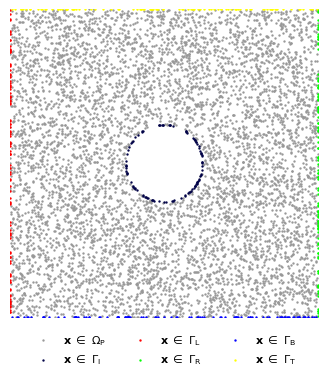

-


In [25]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Parameters
nx = 100
n_Omega_P = 6_400        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 100         # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4 # Inner radius
r_e = np.pi # Outer radius
k = 2.0  # Wave number
iter = 0  # Iteration counter
side_length = 2 * np.pi  # Side length of the square

# Generate random samples for points inside the square but outside the circle
points = []
while len(points) < n_Omega_P:
    x_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
    y_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
    mask = (x_samples**2 + y_samples**2) >= r_i**2
    points.extend(zip(x_samples[mask], y_samples[mask]))

# Trim the list to the desired number of points
points = points[:n_Omega_P]
x_samples, y_samples = zip(*points)

# Convert to numpy arrays
x_f = np.array(x_samples)
y_f = np.array(y_samples)

# Generate random points on the inner boundary (r = r_i)
theta_inner = 2 * np.pi * np.random.rand(n_Gamma_I)  # Uniform angular distribution
x_inner = r_i * np.cos(theta_inner)
y_inner = r_i * np.sin(theta_inner)

# Generate random points on the left, right, bottom, and top boundaries of the square
n_boundary = 100  # Number of points on each boundary

# Left boundary (excluding corners)
y_left = side_length * (np.random.rand(n_boundary) - 0.5)
x_left = -side_length / 2 * np.ones_like(y_left)

# Right boundary (excluding corners)
y_right = side_length * (np.random.rand(n_boundary) - 0.5)
x_right = side_length / 2 * np.ones_like(y_right)

# Bottom boundary (excluding corners)
x_bottom = side_length * (np.random.rand(n_boundary) - 0.5)
y_bottom = -side_length / 2 * np.ones_like(x_bottom)

# Top boundary (excluding corners)
x_top = side_length * (np.random.rand(n_boundary) - 0.5)
y_top = side_length / 2 * np.ones_like(x_top)

# Us teorics for inner boundary
R_inner = np.sqrt(x_inner**2 + y_inner**2)
Theta_inner = np.arctan2(y_inner, x_inner)
u_scn_inner, u_inner_ = u_exact_calc_for_pinns(R_inner, Theta_inner, r_i, k)
u_inner_t = torch.from_numpy(u_scn_inner).to(device)

# Us teorics for left boundary
R_left = np.sqrt(x_left**2 + y_left**2)
Theta_left = np.arctan2(y_left, x_left)
u_scn_left, u_left_ = u_exact_calc_for_pinns(R_left, Theta_left, r_i, k)
u_left_t = torch.from_numpy(u_scn_left).to(device)

# Us teorics for right boundary
R_right = np.sqrt(x_right**2 + y_right**2)
Theta_right = np.arctan2(y_right, x_right)
u_scn_right, u_right_ = u_exact_calc_for_pinns(R_right, Theta_right, r_i, k)
u_right_t = torch.from_numpy(u_scn_right).to(device)

# Us teorics for bottom boundary
R_bottom = np.sqrt(x_bottom**2 + y_bottom**2)
Theta_bottom = np.arctan2(y_bottom, x_bottom)
u_scn_bottom, u_bottom_ = u_exact_calc_for_pinns(R_bottom, Theta_bottom, r_i, k)
u_bottom_t = torch.from_numpy(u_scn_bottom).to(device)

# Us teorics for top boundary
R_top = np.sqrt(x_top**2 + y_top**2)
Theta_top = np.arctan2(y_top, x_top)
u_scn_top, u_top_ = u_exact_calc_for_pinns(R_top, Theta_top, r_i, k)
u_top_t = torch.from_numpy(u_scn_top).to(device)

# Convert to torch tensors
x_f = torch.from_numpy(x_f).float().to(device).requires_grad_(True)
y_f = torch.from_numpy(y_f).float().to(device).requires_grad_(True)
x_inner = torch.from_numpy(x_inner).float().to(device).requires_grad_(True)
y_inner = torch.from_numpy(y_inner).float().to(device).requires_grad_(True)
x_left = torch.from_numpy(x_left).float().to(device).requires_grad_(True)
y_left = torch.from_numpy(y_left).float().to(device).requires_grad_(True)
x_right = torch.from_numpy(x_right).float().to(device).requires_grad_(True)
y_right = torch.from_numpy(y_right).float().to(device).requires_grad_(True)
x_bottom = torch.from_numpy(x_bottom).float().to(device).requires_grad_(True)
y_bottom = torch.from_numpy(y_bottom).float().to(device).requires_grad_(True)
x_top = torch.from_numpy(x_top).float().to(device).requires_grad_(True)
y_top = torch.from_numpy(y_top).float().to(device).requires_grad_(True)


# Plot the points
plt.figure(figsize=(4, 4))
plt.scatter(x_f.cpu().detach().numpy(), y_f.cpu().detach().numpy(), c='#989898ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$")
plt.scatter(x_inner.cpu().detach().numpy(), y_inner.cpu().detach().numpy(), c='#000146ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm I}$")
plt.scatter(x_left.cpu().detach().numpy(), y_left.cpu().detach().numpy(), c='#ff0000ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm L}$")
plt.scatter(x_right.cpu().detach().numpy(), y_right.cpu().detach().numpy(), c='#00ff00ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm R}$")
plt.scatter(x_bottom.cpu().detach().numpy(), y_bottom.cpu().detach().numpy(), c='#0000ffff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm B}$")
plt.scatter(x_top.cpu().detach().numpy(), y_top.cpu().detach().numpy(), c='#ffff00ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm T}$")
plt.xlim([-r_e, r_e])
plt.ylim([-r_e, r_e])
plt.gca().set_aspect('equal', adjustable='box')

# Adjust the legend position and remove the box
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), frameon=False, ncol=3)

# Remove the ticks
plt.axis('off')

# Show the plot
plt.show()

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=150, activation_function=nn.Tanh()).to(device)
# Initialize the weights
model.apply(init_weights)

print('-')

In [26]:
train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top,
          u_inner_t, u_left_t, u_right_t, u_bottom_t, u_top_t, k, num_iter = 10_000)

LBFGS - Loss: 0.36730684489905696
LBFGS - Loss: 0.21058985261425253
LBFGS - Loss: 0.11720297419530185
LBFGS - Loss: 0.08533964805778832
LBFGS - Loss: 0.06805365434806195
LBFGS - Loss: 0.0400476931694048
LBFGS - Loss: 0.019355110266183577
LBFGS - Loss: 0.010153460796337443
LBFGS - Loss: 0.006842542608390385
LBFGS - Loss: 0.004946591717405703
LBFGS - Loss: 0.0035268356179072617
LBFGS - Loss: 0.0025270389266865236
LBFGS - Loss: 0.0018966585484328675
LBFGS - Loss: 0.0014813073583877928
LBFGS - Loss: 0.0011984357136065947
LBFGS - Loss: 0.0009674427550864124
LBFGS - Loss: 0.000817602089376433
LBFGS - Loss: 0.0006996089568248679
LBFGS - Loss: 0.0006163278315246461
LBFGS - Loss: 0.0005482645922332862
LBFGS - Loss: 0.0004916381944826207
LBFGS - Loss: 0.00043585497341392786
LBFGS - Loss: 0.0003902337146046279
LBFGS - Loss: 0.00035156496495231164
LBFGS - Loss: 0.0003215125632000909
LBFGS - Loss: 0.0002953771571779357
LBFGS - Loss: 0.00027111473259358907
LBFGS - Loss: 0.00024402495378513358
LBFGS 

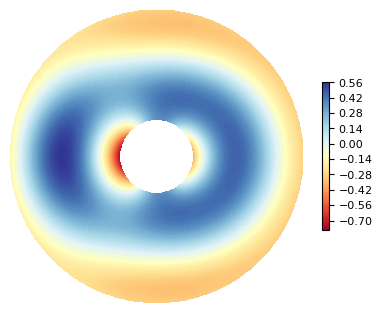

In [29]:
# Número de muestras en x y y
dom_samples = 500
x = np.linspace(-np.pi, np.pi, dom_samples)
y = np.linspace(-np.pi, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    ikx = -1j * x * k
    exp_ikx =  np.exp(ikx)    
    return exp_ikx

R_exact = np.sqrt(X**2 + Y**2) 
u_amp_exact = np.real(u_exact(X, Y, k))

# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 
U_pred = model(domain_ten)
U_real = U_pred[:, 0].detach().cpu().numpy().reshape(X.shape)
U_imag = U_pred[:, 1].detach().cpu().numpy().reshape(X.shape)

u_amp_exact = np.ma.masked_where(R_exact < r_i, u_amp_exact)
u_amp_exact = np.ma.masked_where(R_exact > r_e, u_amp_exact)
U_real = np.ma.masked_where(R_exact < r_i, U_real)
U_real = np.ma.masked_where(R_exact > r_e, U_real)

plt.figure(figsize=(4, 4))


plt.contourf(X, Y, U_real, cmap='RdYlBu', levels=150)
plt.colorbar(shrink=0.4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis("image")
plt.grid(False)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.tight_layout()